In [6]:
import pickle
import numpy as np

In [7]:
import pickle 
with open('ctmc_ctrl_models.pkl', 'rb') as f:
    ctmc_ctrl_models = pickle.load(f)

with open('ctmc_cvi_models.pkl', 'rb') as f:
    ctmc_cvi_models = pickle.load(f)

In [192]:
len(ctmc_ctrl_models.keys())

24

In [8]:
ctmc_cvi_models.keys()

dict_keys(['1044_4', '1023_2', '1047_3', '1056_1', '1053_3', '1039_1', '1046_2', '1043_4', '1020_4', '1039_4', '1046_3', '1047_1', '1022_4', '1027_2', '1050_3', '1043_1', '1026_1', '1034_3', '1028_3', '1052_3', '1031_4', '1028_4', '1046_4', '1042_1', '1013_4', '1028_2', '1048_1', '1019_3', '1046_1', '1017_4', '1023_3', '1039_3', '1040_1', '1042_2', '1049_1', '1010_4', '1040_4', '1051_1', '1034_2', '1039_2', '1048_2', '1031_2', '1045_4', '1050_1', '1043_3', '1018_3', '1031_1', '1018_4', '1037_4', '1020_3', '1054_1', '1042_4', '1048_3', '1024_1', '1033_1', '1035_3', '1034_1', '1027_4', '1028_1', '1051_2', '1042_3', '1013_3', '1047_2', '1023_1', '1022_3', '1010_3', '1027_1'])

In [9]:
ctmc_ctrl_models.keys()

dict_keys(['2015_1', '2018_1', '2019_1', '2038_1', '2014_1', '2045_1', '2024_1', '2037_1', '2025_1', '2039_1', '2023_1', '2011_1', '2013_1', '2026_1', '2009_1', '2040_1', '2044_1', '2017_1', '2010_1', '2036_1', '2022_1', '2043_1', '2008_1', '2031_1'])

In [100]:
ctmc_cvi_models['1044_4'].matrix

array([[0.        , 0.00715699, 0.00139649, 0.        ],
       [0.00541365, 0.        , 0.        , 0.        ],
       [0.        , 0.01505289, 0.        , 0.        ],
       [0.00119943, 0.        , 0.00076328, 0.        ]], dtype=float128)

In [125]:
ctmc_cvi_models['1044_4'].matrix.flatten()[[1,2,3,5,6,7,9,10,11,13,14]].tolist()

[0.007156988246246945188,
 0.0013964855114628185732,
 0.0054136484940907357987,
 0.015052888527257933279,
 0.00076327554247083197037]

In [11]:
cvi_ids = list(set([i.split('_')[0] for i in list(ctmc_cvi_models.keys())]))
ctrl_ids = list(set([i.split('_')[0] for i in list(ctmc_ctrl_models.keys())]))
ctrl_ids.sort()
cvi_ids.sort()

train_ids = ctrl_ids[:-5] + cvi_ids[:-5]
train_labels = [0] * len(ctrl_ids[:-5]) + [1] * len(cvi_ids[:-5])

test_ids = ctrl_ids[-5:] + cvi_ids[-5:]
test_labels = [0] * len(ctrl_ids[-5:]) + [1] * len(cvi_ids[-5:])

In [194]:
len(cvi_ids)

33

In [120]:
X =  ctrl_ids + cvi_ids
y = [0] * len(ctrl_ids) + [1] * len(cvi_ids)

In [160]:
def get_train_test_data(ctmc_cvi_models, ctmc_ctrl_models, train_ids):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for k in ctmc_cvi_models.keys():
        if(k.split('_')[0] in train_ids):
            X_train.append(ctmc_cvi_models[k].matrix.flatten()[[1,2,3,5,6,7,9,10,11,13,14]].tolist())
            y_train.append(1)
        else:
            X_test.append(ctmc_cvi_models[k].matrix.flatten()[[1,2,3,5,6,7,9,10,11,13,14]].tolist())
            y_test.append(1)

    for k in ctmc_ctrl_models.keys():
        if(k.split('_')[0] in train_ids):
            X_train.append(ctmc_ctrl_models[k].matrix.flatten()[[1,2,3,5,6,7,9,10,11,13,14]].tolist())
            y_train.append(0)
        else:
            X_test.append(ctmc_ctrl_models[k].matrix.flatten()[[1,2,3,5,6,7,9,10,11,13,14]].tolist())
            y_test.append(0)
    return X_train, y_train, X_test, y_test

In [188]:
from sklearn.base import BaseEstimator, ClassifierMixin

class dummiesclf(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        ret = np.ones(len(X))
        return ret
    
    def predict_proba(self, X, y=None):
        ret = np.ones(len(X))
        return ret

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# clf = LogisticRegression(random_state=1).fit(training_data, train_labels)

In [206]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

accuracys = []
f1_scores = []
sens_scores = []
spec_scores = []
rec_scores = []
skf = StratifiedKFold(n_splits=3)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_ids = np.array(X)[train_index]
    # train_labels = np.array(y)[train_index]
    test_ids = np.array(X)[test_index]
    # test_labels = np.array(y)[test_index]
    X_train, y_train, X_test, y_test = get_train_test_data(ctmc_cvi_models, ctmc_ctrl_models, train_ids)
    # clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=100, tol=1e-3, alpha=0.01))
    # clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
    # clf = make_pipeline(StandardScaler(), dummiesclf())
    clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=2, random_state=0))
    model = clf.fit(X_train, y_train)

    accuracy = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    cm = confusion_matrix(y_test, clf.predict(X_test))
    sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
    specificity = cm[0,0]/(cm[0,0] + cm[0,1])

    accuracys.append(accuracy)
    f1_scores.append(f1_score(clf.predict(X_test), y_test))
    sens_scores.append(sensitivity)
    spec_scores.append(specificity)
    rec_scores.append(recall_score(clf.predict(X_test), y_test))
    # print(np.sum(clf.predict(X_test) == y_test)/len(y_test))

In [207]:
print(np.mean(accuracys), np.mean(f1_scores), np.mean(sens_scores), np.mean(spec_scores), np.mean(rec_scores))

0.7738095238095238 0.859703856874233 0.9339506172839506 0.375 0.8099477682811016


In [171]:
import shap
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(random_state=42)
explainer = shap.KernelExplainer(model.predict, np.array(X_test, dtype="float64"))
shap_values = explainer.shap_values(np.array(X_test, dtype="float64"))

100%|██████████| 28/28 [00:00<00:00, 200.57it/s]


In [164]:
shap_test = explainer(np.array(X_test, dtype="float64"))

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:00<00:00, 131.63it/s]


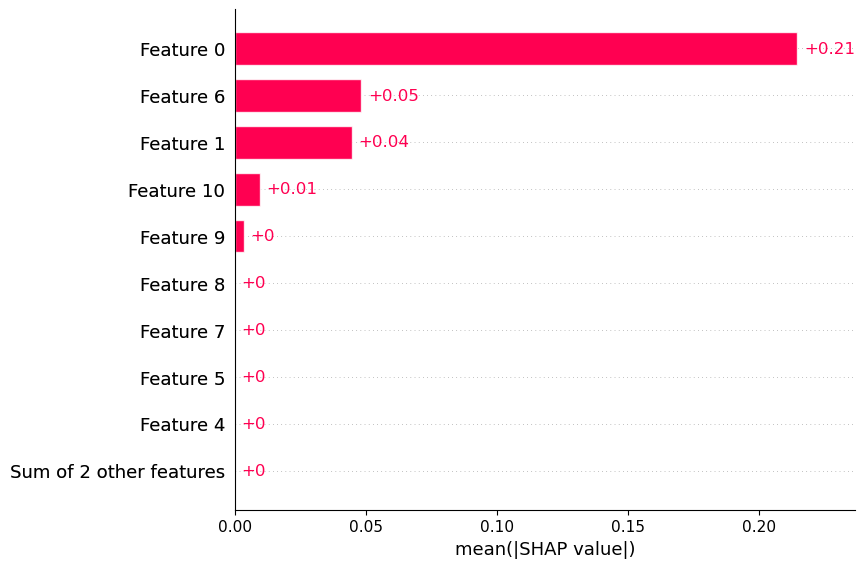

In [165]:
# shap.plots.bar(shap_values)
shap.plots.bar(shap_test)

In [166]:
feature_names = np.array(['INIT to INIT', 'INIT to FIX', 'INIT to SACC', 'INIT to BLINK',
'FIX to INIT', 'FIX to FIX', 'FIX to SACC', 'FIX to BLINK',
'SACC to INIT', 'SACC to FIX', 'SACC to SACC', 'SACC to BLINK',
'BLINK to INIT', 'BLINK to FIX', 'BLINK to SACC', 'BLINK to BLINK',])[[1,2,3,5,6,7,9,10,11,13,14]]
feature_names

array(['INIT to FIX', 'INIT to SACC', 'INIT to BLINK', 'FIX to FIX',
       'FIX to SACC', 'FIX to BLINK', 'SACC to FIX', 'SACC to SACC',
       'SACC to BLINK', 'BLINK to FIX', 'BLINK to SACC'], dtype='<U14')

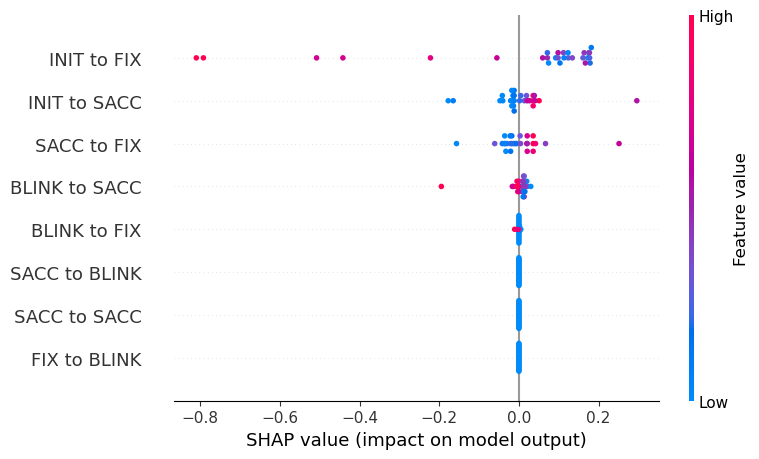

In [172]:
shap.summary_plot(shap_values, np.array(X_test, dtype="float64"), max_display=8, feature_names=feature_names)

In [53]:
shap_values[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
shap.summary_plot(shap_values[0], np.array(X_test, dtype="float64"))

AssertionError: Summary plots need a matrix of shap_values, not a vector.